<h1>Twitter Topic Emotion Analysis - Part 1</h1>
<h2><i>Topic Modeling</i></h2>

In [1]:
### Imports ###
import pandas as pd
from matplotlib import style
style.use('ggplot')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pytz
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aklei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
RUN_TYPE = 0 # Normal Mode (without file creation)
#RUN_TYPE = 1 # Analysis Mode (with file creation)

# Define Ekman's emotions
ekman_emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']

# Timezones
eastern = pytz.timezone("US/Eastern")
european = pytz.timezone("Europe/Berlin")

In [3]:
### Read Data for Topic Modeling ###
def remove_noise(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+httpss\S+", '', text, flags=re.MULTILINE) # Remove Url
    text = re.sub(r"\@w+|\#", '', text) # remove @ and #
    text = re.sub(r"[^\w\s]", '', text) # remove punctuation
    text_tokens = text.split()
    filtered_text = [w for w in text_tokens if not w in stop_words] # remove stopwords
    return " ".join(filtered_text)

if RUN_TYPE == 1:
    df = pd.read_csv('../data/twitter/tweets_isTweet_forTopicAnalysis.csv')
    df['tweet_text'] = df['tweet_text'].fillna('') + '' + df['quoted_tweet_text'].fillna('')
    df['tweet_text'] = df["tweet_text"].apply(lambda x: remove_noise(x))
    df = (df[df['tweet_text'] != ''])
    df['tweet_text'].head()

In [4]:
### Pre process text (embeddings) ###
if RUN_TYPE == 1:
    tweets = df['tweet_text'].values.tolist()
    print(f"[Info] Embedding {len(tweets)} tweets ...")

    # 1. Embedding-Modell (vorher berechnen oder cachen)
    embedder = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = embedder.encode(tweets, show_progress_bar=True)

In [5]:
### Fit BERTopic model and print topic info ###
if RUN_TYPE == 1:
    # 2. UMAP (Reduktion für semantisch klarere Cluster)
    umap_model = UMAP(n_neighbors=50, n_components=20, min_dist=0.05, metric="cosine", random_state=42)

    # 3. HDBSCAN (Cluster-Zahl steuern)
    hdbscan_model = HDBSCAN(min_cluster_size=20, cluster_selection_epsilon=0.3, metric="euclidean", cluster_selection_method="eom", prediction_data=True)

    # 4. CountVectorizer
    vectorizer_model = CountVectorizer(min_df=2, stop_words="english")

    # 5. Repräsentation (optional, für bessere Labels)
    representation_model = KeyBERTInspired()

    # 6.1 Tesla-related seed_words (use to find other topics and populate seed_topic_list)
    seed_words = ["tesla", "elon musk", "autopilot", "cybertruck", "model3", "gigafactory", "electric vehicle", "supercharger", "amp"]

    # 6.2 Tesla-related seed_topic_list (populated by finding broad topics with seed_words and wide clustering, now narrowing it down for accuracy)
    # --> Should not choose to many words as seed_list can become blurry
    seed_topic_list = [
        ["tesla", "elon musk", "autopilot", "cybertruck", "model3", "gigafactory", "electric vehicle", "supercharger"],
        ["president", "trump", "government", "election", "republican", "democrat", "vote", "ballot"],
        ["judge", "activist", "illegal"],
        ["doge", "dogefather"],
        ["spacex", "launch", "falcon", "orbit", "mars"],
        ["bitcoin", "dogecoin"],
        ["starlink", "broadband", "highspeed"],
        ["fertility", "birthrate", "population", "births", "demographic"],
        ["twitter", "tweet", "ban", "free speech", "grok", "grokai"],
        ["crypto", "bitcoin", "dogecoin"],
        ["white", "farmers", "south africa", "field", "genocide"],
        ["afd", "german", "coalition", "berlin"]
    ]

    # 7. Topic-Modell
    topic_model = BERTopic(
        embedding_model=embedder,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        calculate_probabilities=True,
        #seed_topic_list=seed_words, # used to populate seed_topic_list
        seed_topic_list=seed_topic_list,
        nr_topics="auto", # Automatically generate topic count
        verbose=True
    )

    # 8. Fitting
    topics, probs = topic_model.fit_transform(tweets, embeddings)

    # 9. Reduce Outliers
    #new_topics = topic_model.reduce_outliers(tweets, topics, strategy="embeddings") # Method to reduce outliers
    new_topics = topic_model.reduce_outliers(tweets, topics, probabilities=probs, strategy="probabilities") # Method to reduce outliers
    topic_model.update_topics(tweets, topics=new_topics)

In [6]:
# 9. Show Topic Info
if RUN_TYPE == 1:
    topic_model.get_topic_info()

In [7]:
### Create Dataframe from Topic List and Filter Tesla Topic ###
if RUN_TYPE == 1:
    # 1. Get topic info
    topic_info = topic_model.get_topic_info()

    # 2. Create dataframe
    df_topics = pd.DataFrame(topic_info)[['Topic', 'Representation']]
    df_topics.to_csv('../data/twitter/twitter_topics_overview.csv', index=False)

    # 3. Get topic ids with tesla related topics
    tesla_key = "tesla"
    tesla_topic_ids = []

    for _, row in df_topics.iterrows():
        if tesla_key in row['Representation']:
            tesla_topic_ids.append(row['Topic'])

    print(f"Tesla-Topic-IDs: {tesla_topic_ids}")

    # 4. Filter df by documents
    doc_info = topic_model.get_document_info(tweets)
    df['topics'] = doc_info['Topic']
    df_tesla = df[df['topics'].isin(tesla_topic_ids)]

In [8]:
# 5. Drop unnecessary columns and safe to csv
if RUN_TYPE == 1:
    df_tesla = df_tesla[['tweet_id', 'createdAt', 'topics', 'tweet_text_anger', 'tweet_text_fear', 'tweet_text_joy',
       'tweet_text_sadness', 'tweet_text_disgust', 'tweet_text_surprise', 'tweet_text_dominant_emotion', 'total_engagement']]
    df_tesla.to_csv('../data/twitter/tweets_isTweet_emotions_tesla.csv', index=False)
    print(f"Found Tesla-Tweets: {len(df_tesla)}")

<h1>Twitter Topic Emotion Analysis - Part 2</h1>
<h2><i>Event Study</i></h2>
<h3>[2.1][Create Event Study Dataframe]</h3>
<p>
    In this section, the two event studies of the emotion and topic data will be combined in order to examine, if we can observe an effect of the topic data with certain emotions on the stock price / trading volume on the NASDAQ and Xetra.
</p>

In [9]:
### Read necessary dataframes, set index, and convert timezones ###
# Prep tweets
df_tesla = pd.read_csv('../data/twitter/tweets_isTweet_emotions_tesla.csv').dropna()
df_tesla = df_tesla.rename(columns={
    'createdAt': 'timestamp',
    'total_engagement': 'engagement',
    'tweet_text_anger': 'anger',
    'tweet_text_fear': 'fear',
    'tweet_text_joy': 'joy',
    'tweet_text_sadness': 'sadness',
    'tweet_text_disgust': 'disgust',
    'tweet_text_surprise': 'surprise',
    'tweet_text_dominant_emotion': 'tweet_emotion'
})
df_tesla['timestamp'] = pd.to_datetime(df_tesla['timestamp'], format='%a %b %d %H:%M:%S %z %Y', utc=True) # other format, is later converted by tz
if df_tesla['timestamp'].dt.tz is None:
    df_tesla['timestamp'] = df_tesla['timestamp'].dt.tz_localize(eastern)
df_tesla['timestamp'] = df_tesla['timestamp'].dt.tz_convert(eastern)
df_tesla = df_tesla.set_index('timestamp').sort_index()

# Prep nasdaq data
df_nasdaq = (pd.read_csv('../data/stocks/tesla_nasdaq_intraday_202305_202504-1m.csv')
    .rename(columns={'Unnamed: 0': 'timestamp'})
    .drop(columns={'volume'})
)
df_nasdaq['timestamp'] = pd.to_datetime(df_nasdaq['timestamp'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
if df_nasdaq['timestamp'].dt.tz is None:
    df_nasdaq['timestamp'] = df_nasdaq['timestamp'].dt.tz_localize(eastern)
df_nasdaq['timestamp'] = df_nasdaq['timestamp'].dt.tz_convert(eastern)
df_nasdaq = df_nasdaq.set_index('timestamp').sort_index()

# Prep xetra data
df_xetra = (pd.read_csv('../data/stocks/tesla_xetra_intraday_202305_202504-1m.csv')
    .rename(columns={'Unnamed: 0': 'timestamp'})
    .drop(columns={'volume'})
)
df_xetra['timestamp'] = pd.to_datetime(df_xetra['timestamp'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
if df_xetra['timestamp'].dt.tz is None:
    df_xetra['timestamp'] = df_xetra['timestamp'].dt.tz_localize(european)
df_xetra['timestamp'] = df_xetra['timestamp'].dt.tz_convert(european)
df_xetra = df_xetra.set_index('timestamp').sort_index()

In [10]:
### Inspect dataframe ###
print("[Tesla]")
print("Datentyp der Spalte:", df_tesla.index.dtype)
print("Tesla Columns:", df_tesla.columns)
print("Number Tweets:", len(df_tesla))

### Inspect dataframe ###
print("\n[NASDAQ]")
print("Datentyp der Spalte:", df_nasdaq.index.dtype)
print("Tesla Columns:" , df_nasdaq.columns)

### Inspect dataframe ###
print("\n[XETRA]")
print("Datentyp der Spalte:", df_xetra.index.dtype)
print("Tesla Columns:" , df_xetra.columns)

[Tesla]
Datentyp der Spalte: datetime64[ns, US/Eastern]
Tesla Columns: Index(['tweet_id', 'topics', 'anger', 'fear', 'joy', 'sadness', 'disgust',
       'surprise', 'tweet_emotion', 'engagement'],
      dtype='object')
Number Tweets: 521

[NASDAQ]
Datentyp der Spalte: datetime64[ns, US/Eastern]
Tesla Columns: Index(['minute_of_day', 'log_return', 'log_volume', 'log_volume_z'], dtype='object')

[XETRA]
Datentyp der Spalte: datetime64[ns, Europe/Berlin]
Tesla Columns: Index(['minute_of_day', 'log_return', 'log_volume', 'log_volume_z'], dtype='object')


In [11]:
### Group tweets to events with dominant emotion ###
def compute_event_emotion(group):
    total_engagement = group['engagement'].sum()
    weighted_emo_scores = {
        emotion: (group[emotion] * group['engagement']).sum() / total_engagement
        for emotion in ekman_emotions
    }
    event_emotion = max(weighted_emo_scores, key=weighted_emo_scores.get)
    return pd.Series({
        **weighted_emo_scores,
        'event_emotion': event_emotion
    })

if not ('event_emotion' in df_tesla.columns):
    init_len = len(df_tesla)
    # 1. Filter out Tweets outside market hours
    df_tesla = df_tesla[
        df_tesla.index.time >= pd.to_datetime("04:00").time()
    ]
    df_tesla = df_tesla[
        df_tesla.index.time <= pd.to_datetime("18:59").time()
    ]

    # 2. Sort by time
    df_tesla.sort_index()

    # 3. Compute time difference between Tweets
    df_tesla['time_diff'] = df_tesla.index.diff()

    # 4. Cluster Tweets to events with time_diff >= 7h
    df_tesla['new_event'] = df_tesla['time_diff'] > pd.Timedelta(hours=7)

    # 5. Cumulate events in event_id
    df_tesla['event_id'] = df_tesla['new_event'].cumsum()

    # 6. Compute the dominant emotion for each event and merge back to df
    df_event_emotions = (df_tesla
        .drop(columns=['event_id'])
        .groupby(df_tesla['event_id'], group_keys=False)
        .apply(compute_event_emotion)
        .reset_index()
    )

    df_tesla = (df_tesla
        .reset_index()
        .merge(
            df_event_emotions[['event_id', 'event_emotion']],
            on='event_id',
            how='left'
        )
    )
    df_tesla = df_tesla[['timestamp', 'event_id', 'event_emotion']]

    # 7. Set event_time to time of the earliest Tweet of the event (models from what point in time a reaction can occur)
    df_tesla['event_time'] = df_tesla.groupby('event_id')['timestamp'].transform('min')

    # 8. Filter duplicate events
    df_tesla = df_tesla.drop_duplicates(subset=['event_id']).set_index('event_time').sort_index()
    # 9. Show new length (plain events)
    new_len = len(df_tesla)
    rm_lines = init_len - new_len
    print("[Tesla]")
    print(f"[Info] Removed {rm_lines} tuples within events. New length (#tweets): {new_len}")
    print("Datentyp der Spalte:", df_tesla.index.dtype)
    print("Tesla Columns:", df_tesla.columns)

[Tesla]
[Info] Removed 323 tuples within events. New length (#tweets): 198
Datentyp der Spalte: datetime64[ns, US/Eastern]
Tesla Columns: Index(['timestamp', 'event_id', 'event_emotion'], dtype='object')


In [12]:
### Create Event Study DataFrame (with actual, expected, abnormal return and volume ###
# 1. Filter events based on overlaps of estimation and event windows
# 2. Calculate expected and abnormal returns for each event
def filter_events(df_vid: pd.DataFrame, df_fin: pd.DataFrame, fin_tz: str, vid_tz: str = 'US/Eastern', get_pre: int = 0):
    # Define necessary vars
    est = 300
    obs = 180
    gap = est + obs
    results = []

    # 1. Filter by overlaps
    valid_events = []
    last_event = None

    # Add valid events to the list
    for date in df_vid.index:
        # First event always valid
        if last_event is None:
            valid_events.append(date)
            last_event = date
        else:
            # If timeshift > gaps, keep the current event and set as new last_event
            if (date - last_event) > pd.Timedelta(minutes=gap):
                valid_events.append(date)
                last_event = date

    # Only keep valid events
    df_vid = df_vid.loc[valid_events]
    print(f"[Overlap] New df_length: {len(df_vid)}")

    # 2. Align event_time with the next available trading timestamp
    # 2.1 Convert both their respective timezone if not yet set
    if df_vid.index.tz is None:
        df_vid.index = df_vid.index.tz_localize(vid_tz)
    elif df_vid.index.tz != vid_tz:
        df_vid.index = df_vid.index.tz_convert(vid_tz)

    # 2.2 Convert all timezones to utc (+00:00)
    df_vid.index = df_vid.index.tz_convert('UTC')
    df_fin.index = df_fin.index.tz_convert('UTC')

    # 2.3 Align vid and fin times
    for i, date in enumerate(df_vid.index):
        if date not in df_fin.index:
            future_times = df_fin.index[df_fin.index > date]
            if not future_times.empty:
                df_vid.index.values[i] = pd.Timestamp(future_times[0])

    # 3. Filter events without sufficient estimation_window data
    # 4. Filter events without sufficient event_window data
    valid_events = []

    for date in df_vid.index:
        day_data = df_fin[df_fin.index.date == date.date()]
        event_index = day_data.index.get_loc(date)

        remaining = len(day_data) - event_index

        if event_index >= est:
            if remaining >= obs:
                valid_events.append(date)

    df_vid = df_vid.loc[valid_events]
    print(f"[Sum Data] New df_length = {len(df_vid)}")

    # 5. Event study variables
    for event_row in df_vid.itertuples():
        event_id = event_row.event_id
        event_emo = event_row.event_emotion
        event_time = event_row.Index

        # 5.1 Compute estimation_ and event_window
        estimation_window = df_fin.loc[
            event_time - pd.Timedelta(minutes=est) : event_time - pd.Timedelta(minutes=1)
        ]
        event_window = df_fin.loc[
            event_time - pd.Timedelta(minutes=get_pre * est): event_time + pd.Timedelta(minutes=obs - 1)
        ]

        # 5.2 Compute expected values based on estimation window
        expected_return = estimation_window['log_return'].mean()
        expected_volume = estimation_window['log_volume'].median() # robust against outliers, see Bamber (1987)

        for i, fin_row in enumerate(event_window.itertuples()):
            if get_pre == 1:
                i = int((fin_row.Index - event_time).total_seconds() // 60)

            # 5.3 Compute actual and abnormal values
            actual_return = fin_row.log_return
            abnormal_return = actual_return - expected_return

            actual_volume = fin_row.log_volume
            abnormal_volume = actual_volume - expected_volume

            results.append({
                'event_id': event_id,
                'event_fin_offset': i,
                'event_time': event_time,
                'fin_time': fin_row.Index,
                'event_emo': event_emo,
                'actual_return': actual_return,
                'expected_return': expected_return,
                'abnormal_return': abnormal_return,
                'actual_volume': actual_volume,
                'expected_volume': expected_volume,
                'abnormal_volume': abnormal_volume,
            })

    # 5.4 Make dataframe from results containing metrics
    df_valid_events = pd.DataFrame(results)

    return df_valid_events

In [13]:
### Create event_study and event_study_pre_post dataframes ###
if RUN_TYPE == 1:
    df_tesla = df_tesla[['event_id', 'event_emotion']] # index = event_time
    df_nasdaq = df_nasdaq[['log_return', 'log_volume']] # index = timestamp
    df_xetra = df_xetra[['log_return', 'log_volume']] # index = timestamp

    for df_stock_exchange, name in zip([df_nasdaq, df_xetra], ['nasdaq', 'xetra']):
        if name == 'df_nasdaq':
            fin_timezone = pytz.timezone("US/Eastern")
        else:
            fin_timezone = pytz.timezone("Europe/Berlin")

        # Create dfs (for inspection of results)
        df_event_study = filter_events(df_tesla, df_stock_exchange, fin_tz=fin_timezone)
        df_event_study_pre_post = filter_events(df_tesla, df_stock_exchange, fin_tz=fin_timezone, get_pre=1)

        # Saving as file
        df_event_study.to_csv(f'../data/twitter/twitter_{name}_event_study_top_emo.csv')
        df_event_study_pre_post.to_csv(f'../data/twitter/twitter_{name}_event_study_top_emo_pre_post')

        # Inspection of results
        print(f"[Info][{name}] Dataframe Inspection")
        print(f"Emotions: {df_event_study['event_emo'].unique()}")
        emotion = df_event_study['event_emo'].unique()
        for emo in emotion:
            print(f"  - {emo}: {len(df_event_study[df_event_study['event_emo'] == emo].groupby('event_id'))} events")

        print(f"\n[Info][{name}] Event Study DataFrame has {len(df_event_study)} entries.")
        print(f"[Info] Event Study Pre/Post DataFrame has {len(df_event_study_pre_post)} entries.\n")
        if (df_event_study_pre_post.columns == df_event_study.columns).all():
            print("[Info] emotion_event_study(_pre_post).csv files have the following columns:")
            print(df_event_study.columns.tolist())

<h3>[2.2][Event Study on Return]</h3>
<h4><u>2.2.1 Abnormal Return</u></h4>
<p>[Intro]</p>
<p>In the following it is analysed to what extent a significant effect of a particular emotion on the change in stock return can be observed by the minute<br>
--> Is the mean abnormal return significantly greater / lower than 0 resp. does the mean abnormal return significantly differ from the expected return?</p>
<p>
    <ul>
        <li>H0: mean abnormal return = 0</li>
        <li>H1: mean abnormal return >< 0</li>
    </ul>
</p>

In [14]:
### Read event study dataframes ###
df_event_study_nasdaq = pd.read_csv('../data/twitter/twitter_nasdaq_event_study_top_emo.csv')
df_event_study_nasdaq_pre_post = pd.read_csv('../data/twitter/twitter_nasdaq_event_study_top_emo_pre_post')
df_event_study_xetra = pd.read_csv('../data/twitter/twitter_xetra_event_study_top_emo.csv')
df_event_study_xetra_pre_post = pd.read_csv('../data/twitter/twitter_xetra_event_study_top_emo_pre_post')

In [15]:
### Significance Testing of AR ###
# Variables
alpha = 0.05
nasdaq_res = pd.DataFrame()
xetra_res = pd.DataFrame()

# Functions
def stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return ''

def test_abnormal_returns(df, test_col):
    results = []

    emotions = df['event_emo'].unique()
    minutes = df['event_fin_offset'].unique()

    for minute in minutes:
        row = {'minute': minute}

        for emo in emotions:
            values = df.loc[
                (df['event_fin_offset'] == minute) & (df['event_emo'] == emo),
                test_col
            ]
            if len(values) > 1:
                t_stat, p_value = stats.ttest_1samp(values, 0)
                row[f'{emo}_{test_col}_mean'] = values.mean()
                row[f'{emo}_{test_col}_t_stat'] = t_stat
                row[f'{emo}_{test_col}_p_value'] = p_value
                row[f'{emo}_{test_col}_sig'] = f"{t_stat:.2f}{stars(p_value)}" # adds stars
            else:
                row[f'{emo}_{test_col}_mean'] = np.nan
                row[f'{emo}_{test_col}_t_stat'] = np.nan
                row[f'{emo}_{test_col}_p_value'] = np.nan
                row[f'{emo}_{test_col}_sig'] = ''

        results.append(row)
    return pd.DataFrame(results)

for df_stock_exchange, name in zip([df_event_study_nasdaq, df_event_study_xetra], ['nasdaq', 'xetra']):
    ar_test_scores = test_abnormal_returns(df_stock_exchange, 'abnormal_return')
    ar_test_scores.set_index('minute', inplace=True)

    # Safe exchange specific results
    if name == 'nasdaq':
        nasdaq_res = ar_test_scores
    if name == 'xetra':
        xetra_res = ar_test_scores

In [16]:
xetra_res

,sadness_abnormal_return_mean,sadness_abnormal_return_t_stat,sadness_abnormal_return_p_value,sadness_abnormal_return_sig,anger_abnormal_return_mean,anger_abnormal_return_t_stat,anger_abnormal_return_p_value,anger_abnormal_return_sig,joy_abnormal_return_mean,joy_abnormal_return_t_stat,joy_abnormal_return_p_value,joy_abnormal_return_sig,fear_abnormal_return_mean,fear_abnormal_return_t_stat,fear_abnormal_return_p_value,fear_abnormal_return_sig
minute,,,,,,,,,,,,,,,,
0,-0.000010,-1.021277,0.382298,-1.02,-0.000090,-1.569675,0.123060,-1.57,0.000233,1.832270,0.070728,1.83,-0.000003,-0.130580,0.904372,-0.13
1,-0.000848,-1.011574,0.386244,-1.01,-0.000058,-1.119810,0.268367,-1.12,-0.000093,-1.336349,0.185321,-1.34,-0.000003,-0.130580,0.904372,-0.13
2,0.000048,0.818334,0.473118,0.82,-0.000249,-1.415573,0.163356,-1.42,0.000278,1.791725,0.077055,1.79,-0.000003,-0.130580,0.904372,-0.13
3,-0.000300,-1.033073,0.377552,-1.03,0.000014,0.527356,0.600376,0.53,-0.000034,-0.185255,0.853510,-0.19,-0.000003,-0.130580,0.904372,-0.13
4,-0.000010,-1.021277,0.382298,-1.02,0.000100,0.635960,0.527823,0.64,0.000018,0.163834,0.870286,0.16,-0.000003,-0.130580,0.904372,-0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-0.001322,-1.007416,0.387947,-1.01,0.000054,0.872701,0.387171,0.87,-0.000340,-1.630314,0.107067,-1.63,-0.000003,-0.130580,0.904372,-0.13
176,0.000736,0.986815,0.396490,0.99,-0.000190,-1.284647,0.205081,-1.28,-0.000013,-0.319170,0.750451,-0.32,-0.000003,-0.130580,0.904372,-0.13
177,-0.001235,-1.007940,0.387732,-1.01,0.000021,0.102134,0.919075,0.10,0.000053,0.652472,0.516015,0.65,-0.000003,-0.130580,0.904372,-0.13


In [17]:
### Show exchange specific results ###
# Make list of p_value columns

for res, name in zip([nasdaq_res, xetra_res], ['nasdaq', 'xetra']):
    pval_cols = [col for col in res.columns if col.endswith('_p_value')]

    # Safe rows where at least one p-value is below alpha (significant)
    if name == 'nasdaq':
        nasdaq_sig_rows = res[(res[pval_cols] < alpha).any(axis=1)]
        nasdaq_sig_cols = [col for col in nasdaq_sig_rows.columns if col.endswith('_sig')]
    if name == 'xetra':
        xetra_sig_rows = res[(res[pval_cols] < alpha).any(axis=1)]
        xetra_sig_cols = [col for col in xetra_sig_rows.columns if col.endswith('_sig')]

print("[NASDAQ]\n", nasdaq_sig_rows[nasdaq_sig_cols])
print("\n[XETRA]\n", xetra_sig_rows[xetra_sig_cols])

[NASDAQ]
        sadness_abnormal_return_sig anger_abnormal_return_sig  \
minute                                                         
2                            -0.98                    -2.41*   
3                           -3.81*                      0.95   
4                            -1.66                     -1.95   
5                            -0.62                      0.89   
21                            0.63                    -2.34*   
22                           4.04*                     -1.37   
28                            1.12                      0.37   
31                            0.17                      1.06   
45                           -0.17                      1.40   
70                           -0.81                    -2.36*   
90                           -2.97                     -0.86   
97                           -0.90                   -2.84**   
98                            2.38                      0.35   
121                          -

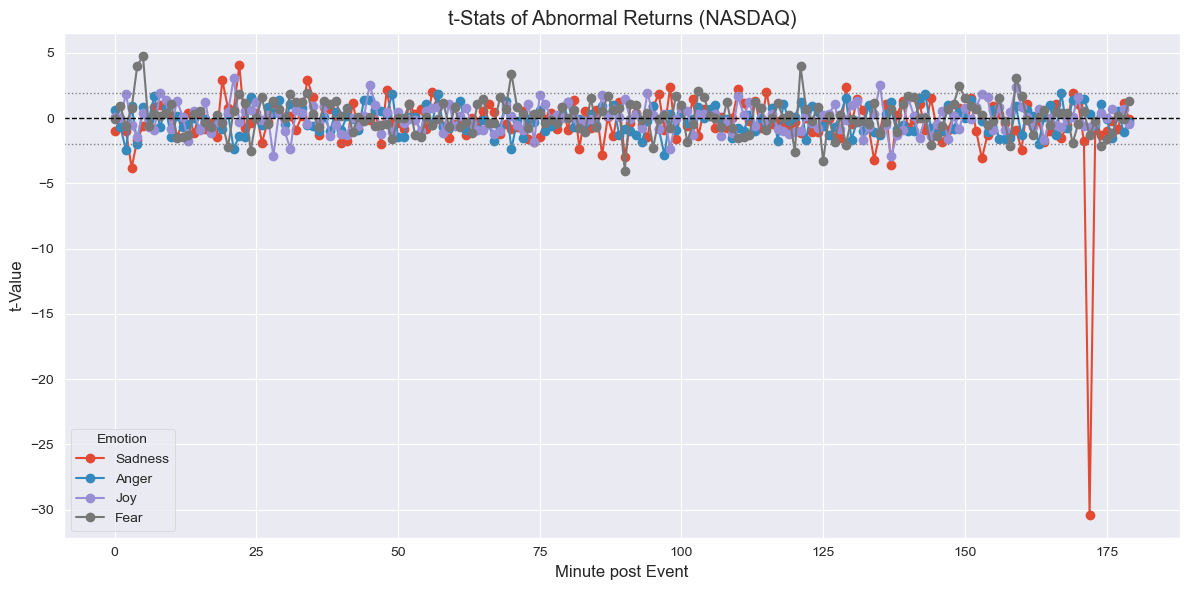

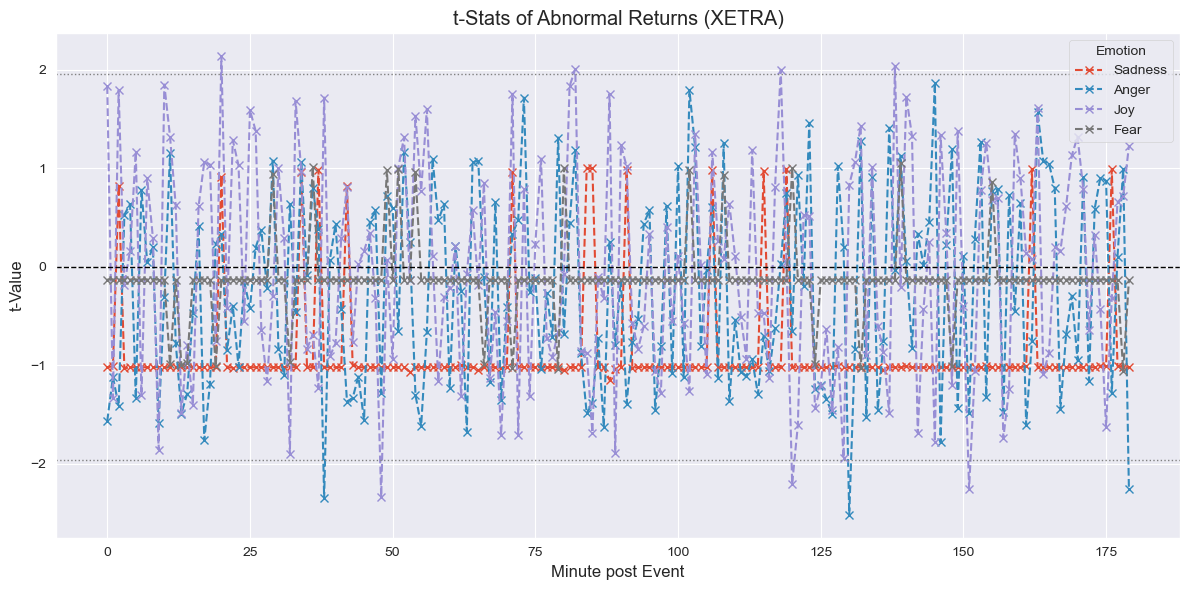

In [28]:
import matplotlib.pyplot as plt

# Emotionen aus den Spalten extrahieren (nehmen wir von NASDAQ)
t_stat_cols = [col for col in nasdaq_res.columns if col.endswith('_t_stat')]
emotions = [col.split('_')[0] for col in t_stat_cols]

# ---------- NASDAQ Plot ----------
plt.figure(figsize=(12, 6))
for emo in emotions:
    col = f"{emo}_abnormal_return_t_stat"
    if col in nasdaq_res.columns:
        plt.plot(nasdaq_res.index, nasdaq_res[col], label=emo.capitalize(), linestyle='-', marker='o')

plt.axhline(1.96, color='gray', linestyle='dotted', linewidth=1) # is p = 0.05
plt.axhline(-1.96, color='gray', linestyle='dotted', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title("t-Stats of Abnormal Returns (NASDAQ)")
plt.xlabel("Minute post Event")
plt.ylabel("t-Value")
plt.legend(title="Emotion")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- XETRA Plot ----------
plt.figure(figsize=(12, 6))
for emo in emotions:
    col = f"{emo}_abnormal_return_t_stat"
    if col in xetra_res.columns:
        plt.plot(xetra_res.index, xetra_res[col], label=emo.capitalize(), linestyle='--', marker='x')

plt.axhline(1.96, color='gray', linestyle='dotted', linewidth=1)
plt.axhline(-1.96, color='gray', linestyle='dotted', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title("t-Stats of Abnormal Returns (XETRA)")
plt.xlabel("Minute post Event")
plt.ylabel("t-Value")
plt.legend(title="Emotion")
plt.grid(True)
plt.tight_layout()
plt.show()


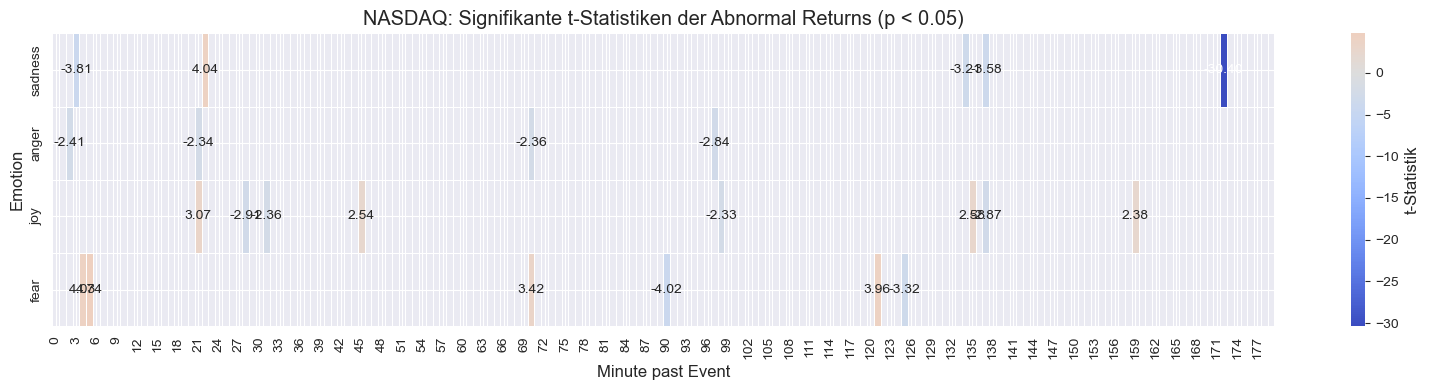

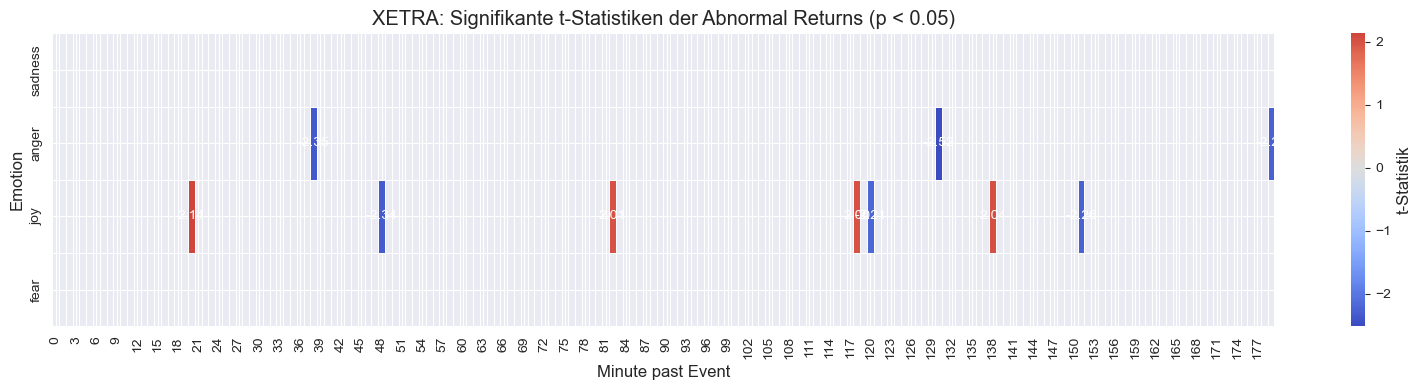

In [19]:
def plot_heatmaps(nasdaq_res, xetra_res, alpha=0.05):
    def prepare_heatmap_data(res_df):
        # Nur Spalten mit "_abnormal_return_t_stat"
        emotions = [col.split('_')[0] for col in res_df.columns if col.endswith('_abnormal_return_t_stat')]

        heatmap_data = pd.DataFrame({
            emo: res_df[f"{emo}_abnormal_return_t_stat"] for emo in emotions
        }).T

        pvalue_data = pd.DataFrame({
            emo: res_df[f"{emo}_abnormal_return_p_value"] for emo in emotions
        }).T

        # Nur signifikante Werte behalten
        heatmap_data = heatmap_data.where(pvalue_data < alpha)

        return heatmap_data, emotions

    # Daten vorbereiten
    nasdaq_heatmap, _ = prepare_heatmap_data(nasdaq_res)
    xetra_heatmap, _ = prepare_heatmap_data(xetra_res)

    # Plot für NASDAQ
    plt.figure(figsize=(16, 4))
    sns.heatmap(
        nasdaq_heatmap,
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f",
        mask=nasdaq_heatmap.isnull(),
        cbar_kws={'label': 't-Statistik'},
        linewidths=.5
    )
    plt.xlabel("Minute past Event")
    plt.ylabel("Emotion")
    plt.title("NASDAQ: Signifikante t-Statistiken der Abnormal Returns (p < 0.05)")
    plt.tight_layout()
    plt.show()

    # Plot für XETRA
    plt.figure(figsize=(16, 4))
    sns.heatmap(
        xetra_heatmap,
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f",
        mask=xetra_heatmap.isnull(),
        cbar_kws={'label': 't-Statistik'},
        linewidths=.5
    )
    plt.xlabel("Minute past Event")
    plt.ylabel("Emotion")
    plt.title("XETRA: Signifikante t-Statistiken der Abnormal Returns (p < 0.05)")
    plt.tight_layout()
    plt.show()

# Aufruf
plot_heatmaps(nasdaq_res, xetra_res)

<h4><u>2.2.1 Cumulative Abnormal Return</u></h4>
<p>[Intro]</p>
<p>
    In the following it is analysed, whether an effect occurs within specified time windows. As log returns are additive, we can use the cumsum() Method to compute the cumulative sum and plot it over time. This way, we can yield a graph that shows the actual return over time and how the abnormal return deviates after the event.
</p>

#################################################################################################################

[Analysis][Info] Performing CAR/CAAR Analysis for nasdaq stock exchange

[Overall]

[Plot] Plotting cumulative log returns for overall events.
[Info] CUmulative Average Abnormal Return (CAAR) for all events over the event window: -0.1833 %
.


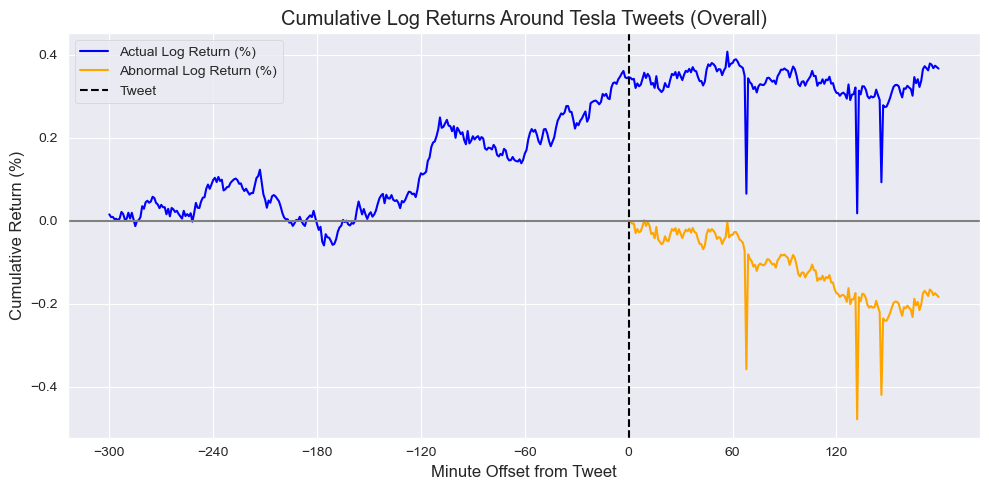

-----------------------------------------------------------------------------------------------------------------

[Emotions]

[Plot] Plotting cumulative log returns for emotion: sadness
[Info] Cumulative Average Abnormal Return (CAAR) for sadness over the event window: -1.2471 %



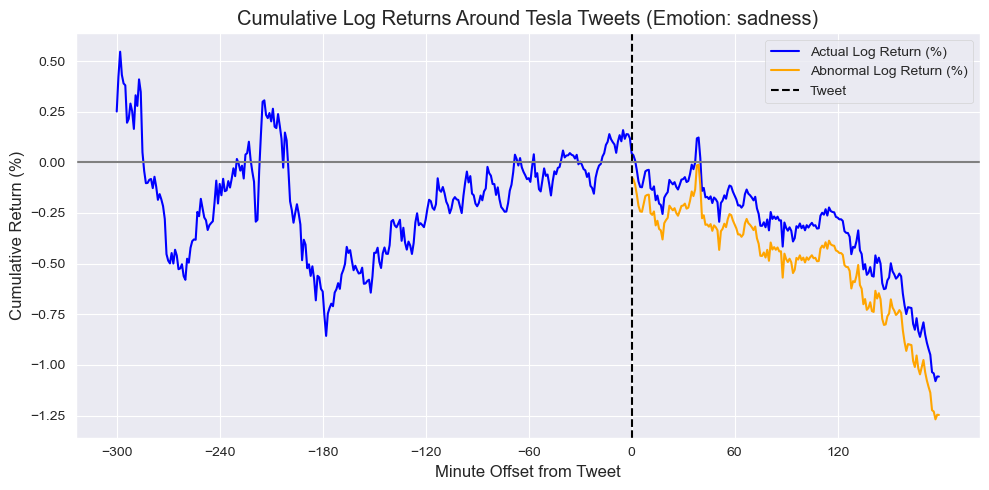

[Plot] Plotting cumulative log returns for emotion: anger
[Info] Cumulative Average Abnormal Return (CAAR) for anger over the event window: -0.3607 %



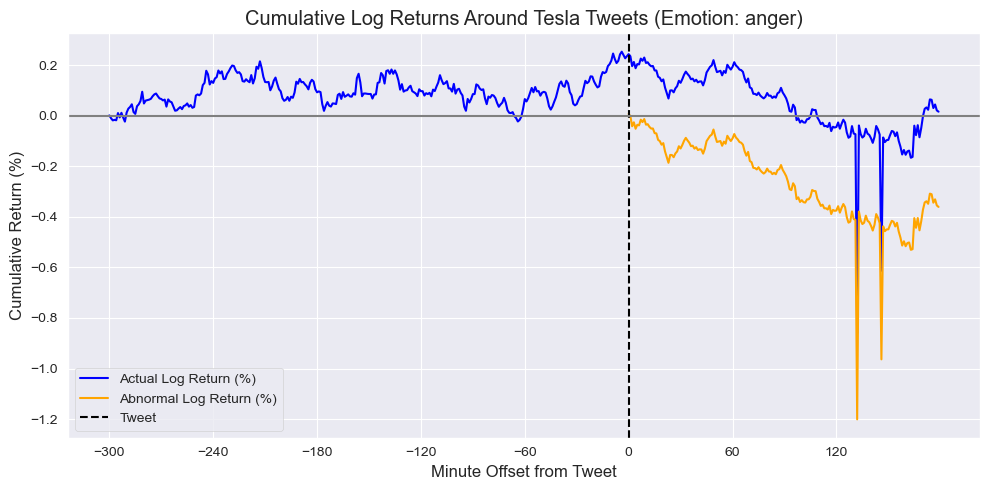

[Plot] Plotting cumulative log returns for emotion: joy
[Info] Cumulative Average Abnormal Return (CAAR) for joy over the event window: -0.0633 %



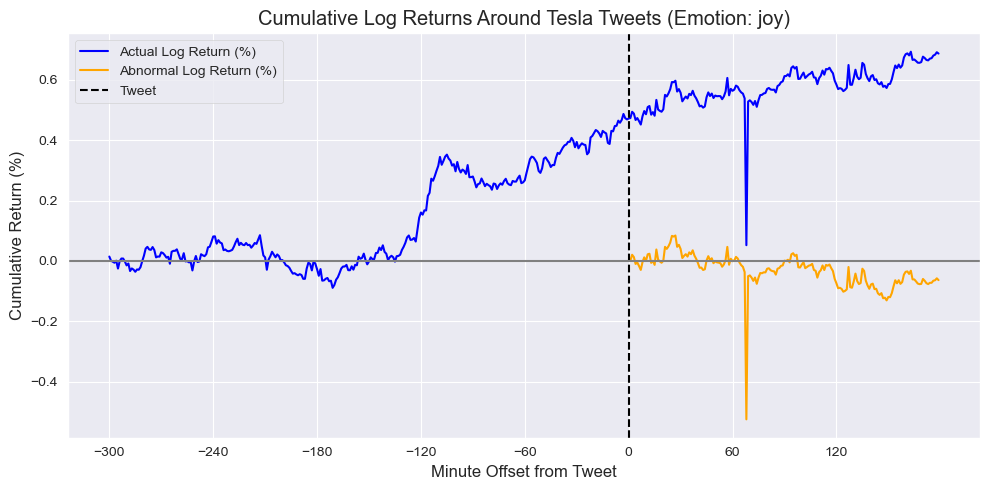

[Plot] Plotting cumulative log returns for emotion: fear
[Info] Cumulative Average Abnormal Return (CAAR) for fear over the event window: 0.7716 %



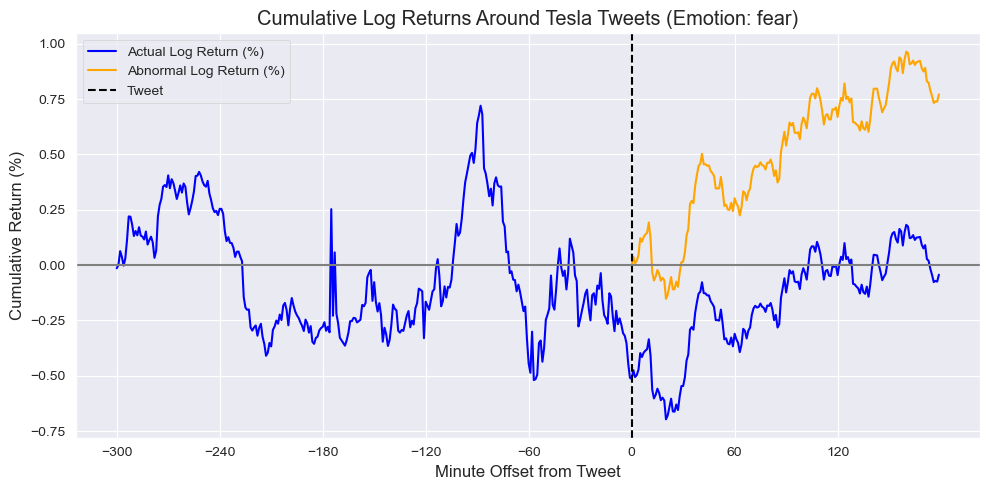

#################################################################################################################

[Analysis][Info] Performing CAR/CAAR Analysis for xetra stock exchange

[Overall]

[Plot] Plotting cumulative log returns for overall events.
[Info] CUmulative Average Abnormal Return (CAAR) for all events over the event window: -0.1856 %
.


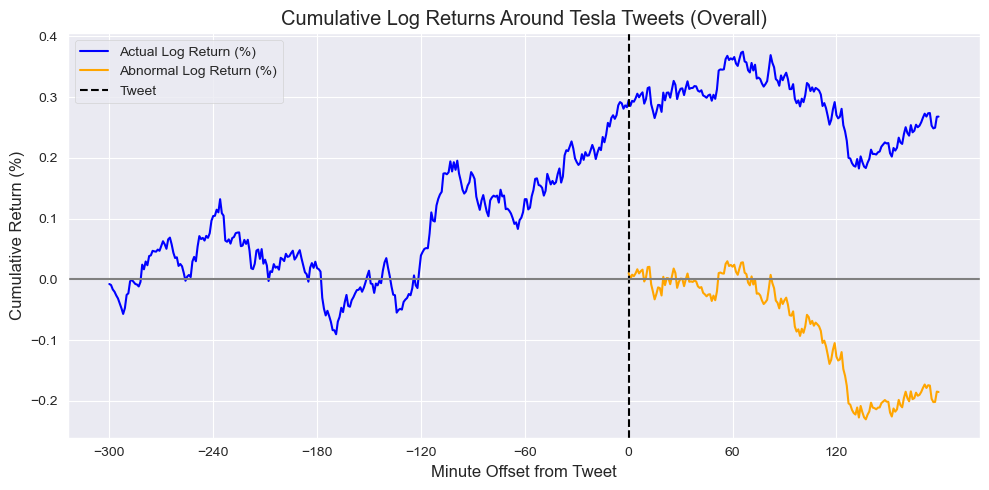

-----------------------------------------------------------------------------------------------------------------

[Emotions]

[Plot] Plotting cumulative log returns for emotion: sadness
[Info] Cumulative Average Abnormal Return (CAAR) for sadness over the event window: -0.9843 %



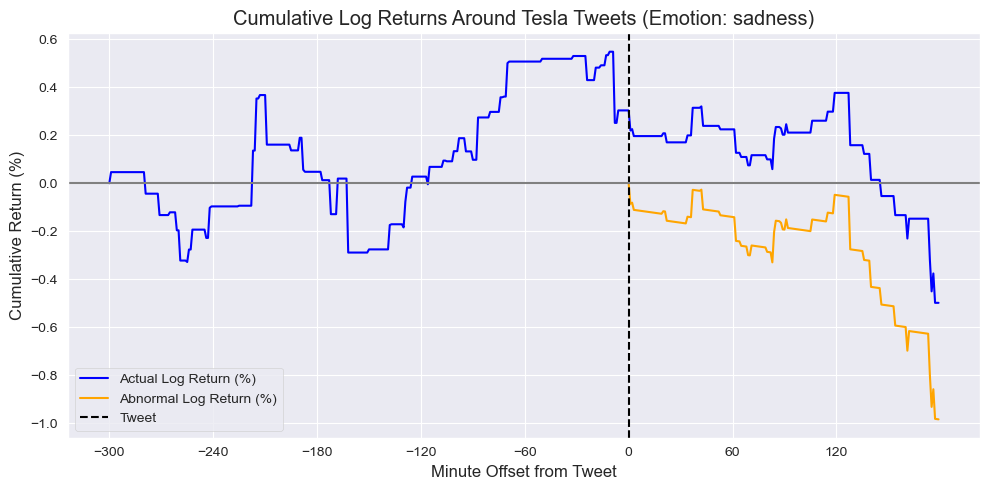

[Plot] Plotting cumulative log returns for emotion: anger
[Info] Cumulative Average Abnormal Return (CAAR) for anger over the event window: -0.4332 %



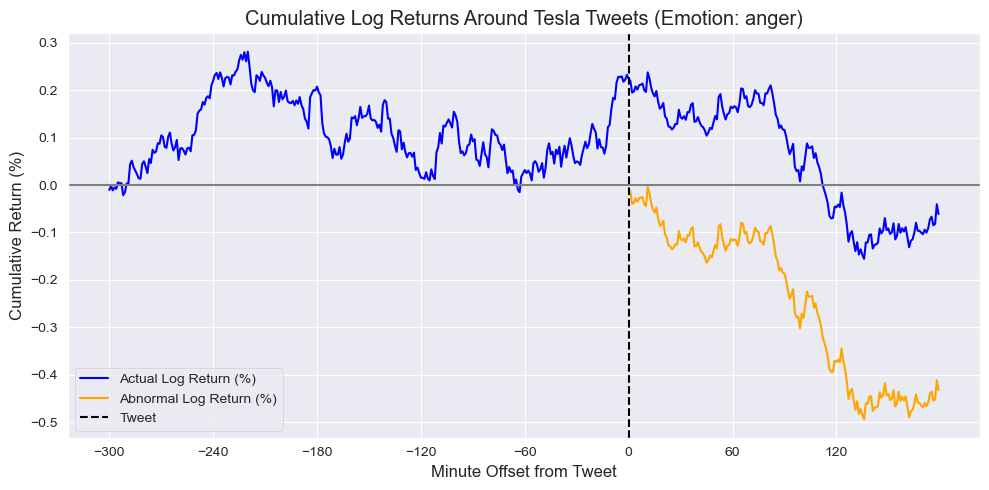

[Plot] Plotting cumulative log returns for emotion: joy
[Info] Cumulative Average Abnormal Return (CAAR) for joy over the event window: 0.0065 %



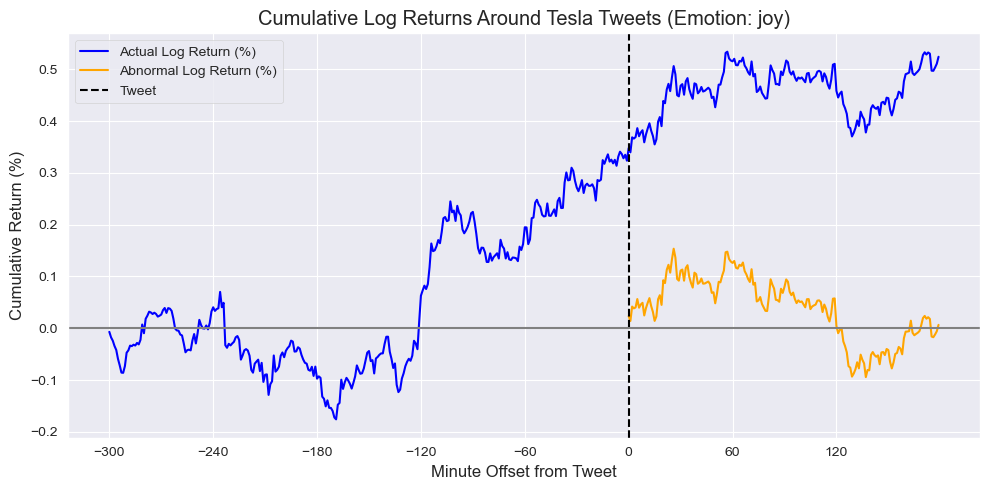

[Plot] Plotting cumulative log returns for emotion: fear
[Info] Cumulative Average Abnormal Return (CAAR) for fear over the event window: -0.1489 %



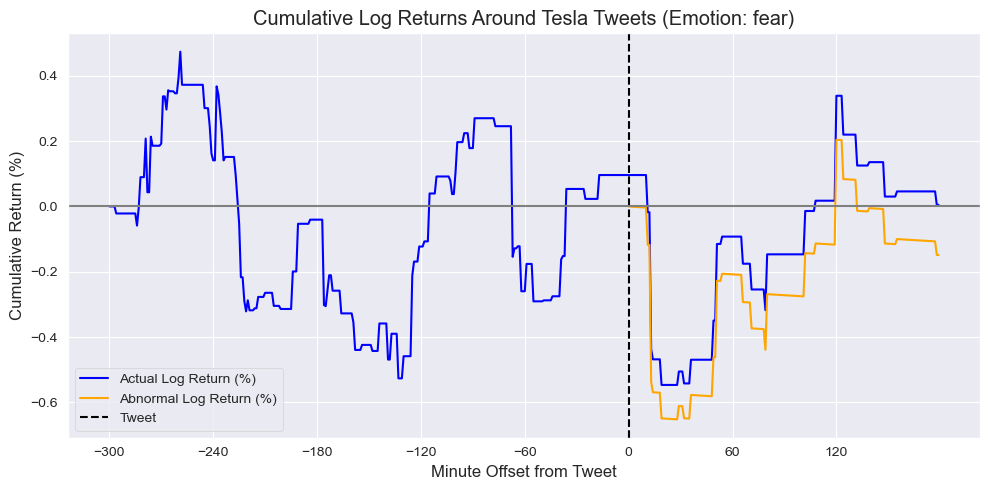

In [20]:
### [All emotions] Plotting Cumulative Log Returns Around Tweet by Emotion ###

nasdaq_emotions = df_event_study_nasdaq_pre_post['event_emo'].unique()
xetra_emotions = df_event_study_xetra_pre_post['event_emo'].unique()

# Loop over two dataframes
for stock_exchange, name in zip([nasdaq_emotions, xetra_emotions], ['nasdaq', 'xetra']):
    print("#################################################################################################################\n")
    print(f'[Analysis][Info] Performing CAR/CAAR Analysis for {name} stock exchange\n')
    # Loop over emotions within dataframe
    if name == 'nasdaq':
        estimation_window = df_event_study_nasdaq_pre_post
        event_window = df_event_study_nasdaq_pre_post[df_event_study_nasdaq_pre_post['event_fin_offset'] >= 0]
    if name == 'xetra':
        estimation_window = df_event_study_xetra_pre_post
        event_window = df_event_study_xetra_pre_post[df_event_study_xetra_pre_post['event_fin_offset'] >= 0]

    for emo, i in zip(emotions, range(len(emotions))):
        # 0.5 Plot Overall Cumulative Log Returns Around Tweets
        if i == 0:
            actual_returns = estimation_window.groupby('event_fin_offset')['actual_return'].mean()
            cumulative_actual_return = actual_returns.cumsum()

            abnormal_returns = event_window.groupby('event_fin_offset')['abnormal_return'].mean()
            cumulative_abnormal_return = abnormal_returns.cumsum()

            caar = abnormal_returns.sum()
            print("[Overall]\n")
            print("[Plot] Plotting cumulative log returns for overall events.")
            print(f"[Info] CUmulative Average Abnormal Return (CAAR) for all events over the event window: {caar * 100:.4f} %\n.")
            plt.figure(figsize=(10, 5))
            plt.plot(cumulative_actual_return.index, cumulative_actual_return.values * 100, label="Actual Log Return (%)", color="blue")
            plt.plot(cumulative_abnormal_return.index, cumulative_abnormal_return.values * 100, label="Abnormal Log Return (%)", color="orange")
            plt.axvline(0, linestyle="--", color="black", label="Tweet")
            plt.axhline(0, linestyle="-", color="gray")
            plt.title("Cumulative Log Returns Around Tesla Tweets (Overall)")
            plt.xlabel("Minute Offset from Tweet")
            plt.xticks([-300, -240, -180, -120, -60, 0, 60, 120])
            plt.ylabel("Cumulative Return (%)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            print("-----------------------------------------------------------------------------------------------------------------\n")
            print("[Emotions]\n")

        # 1. Calculate cumulative actual log returns around tweets
        actual_returns = estimation_window[estimation_window['event_emo'] == emo].groupby('event_fin_offset')['actual_return'].mean()
        cumulative_actual_return = actual_returns.cumsum()

        # 2. Caluculate cumulative abnormal log returns around tweets
        abnormal_returns = event_window[event_window['event_emo'] == emo].groupby('event_fin_offset')['abnormal_return'].mean()
        cumulative_abnormal_return = abnormal_returns.cumsum()

        # 3. Plot
        # Print CAR over the event window
        caar = abnormal_returns.sum()  # Sum of mean abnormal returns over the event window (caar)
        print(f"[Plot] Plotting cumulative log returns for emotion: {emo}")
        print(f"[Info] Cumulative Average Abnormal Return (CAAR) for {emo} over the event window: {caar* 100:.4f} %\n")
        plt.figure(figsize=(10, 5))
        plt.plot(cumulative_actual_return.index, cumulative_actual_return.values * 100, label="Actual Log Return (%)", color="blue")
        plt.plot(cumulative_abnormal_return.index, cumulative_abnormal_return.values * 100, label="Abnormal Log Return (%)", color="orange")
        plt.axvline(0, linestyle="--", color="black", label="Tweet")
        plt.axhline(0, linestyle="-", color="gray")
        plt.title("Cumulative Log Returns Around Tesla Tweets (Emotion: " + emo + ")")
        plt.xlabel("Minute Offset from Tweet")
        plt.xticks([-300, -240, -180, -120, -60, 0, 60, 120])
        plt.ylabel("Cumulative Return (%)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [21]:
def test_car_significance(df: pd.DataFrame, se_emotions: np.ndarray):
    windows = [(0, 1), (0, 2), (0, 5), (0, 10), (0, 30), (0, 60), (0, 120)]
    results = []

    # First test overall effect (no emotion filter)
    for start, end in windows:
        window = df[
            (df['event_fin_offset'] >= start) &
            (df['event_fin_offset'] <= end)
        ]

        event_car = window.groupby('event_id')['abnormal_return'].sum()

        if len(event_car) > 1:  # Need at least 2 observations for t-test
            mean_car = event_car.mean()
            t_stat, p_value = stats.ttest_1samp(event_car, 0)
        else:
            mean_car = event_car.mean() if len(event_car) == 1 else np.nan
            t_stat, p_value = np.nan, np.nan

        results.append({
            'emotion': 'all',
            'window': f"[{start}, {end}]",
            'mean_car': f"{mean_car * 100:.4f} %" if not np.isnan(mean_car) else "NaN",
            't_stat': f"{round(t_stat, 2)}{stars(p_value)}" if not np.isnan(t_stat) else "NaN",
            'n_events': len(event_car)
        })

    # Then test for each emotion
    for se_emo in se_emotions:
        for start, end in windows:
            emo_window = df[
                (df['event_emo'] == se_emo) &
                (df['event_fin_offset'] >= start) &
                (df['event_fin_offset'] <= end)
            ]

            event_car = emo_window.groupby('event_id')['abnormal_return'].sum()

            if len(event_car) > 1:
                mean_car = event_car.mean()
                t_stat, p_value = stats.ttest_1samp(event_car, 0)
            else:
                mean_car = event_car.mean() if len(event_car) == 1 else np.nan
                t_stat, p_value = np.nan, np.nan

            results.append({
                'emotion': se_emo,
                'window': f"[{start}, {end}]",
                'mean_car': f"{mean_car * 100:.4f} %" if not np.isnan(mean_car) else "NaN",
                't_stat': f"{round(t_stat, 2)}{stars(p_value)}" if not np.isnan(t_stat) else "NaN",
                'n_events': len(event_car)
            })

    return pd.DataFrame(results)

# Ensure emotions are properly defined
nasdaq_emotions = [emo for emo in df_event_study_nasdaq['event_emo'].unique() if pd.notna(emo)]
xetra_emotions = [emo for emo in df_event_study_xetra['event_emo'].unique() if pd.notna(emo)]

df_nasdaq_car_results = test_car_significance(df_event_study_nasdaq, nasdaq_emotions)
df_xetra_car_results = test_car_significance(df_event_study_xetra, xetra_emotions)

In [22]:
### Print NASDAQ results ###
for emo in ['all'] + [e for e in df_nasdaq_car_results['emotion'].unique() if e != 'all']:
    if emo == 'all' or pd.notna(emo):
        print(f"\n[Info] Results for emotion '{emo}':")
        emo_results = df_nasdaq_car_results[df_nasdaq_car_results['emotion'] == emo]
        print(emo_results[['window', 'mean_car', 't_stat', 'n_events']])


[Info] Results for emotion 'all':
     window   mean_car t_stat  n_events
0    [0, 1]  -0.0013 %   -0.1       138
1    [0, 2]  -0.0066 %  -0.39       138
2    [0, 5]  -0.0196 %  -0.78       138
3   [0, 10]  -0.0122 %  -0.36       138
4   [0, 30]  -0.0308 %  -0.44       138
5   [0, 60]  -0.0338 %  -0.35       138
6  [0, 120]  -0.1741 %  -1.25       138

[Info] Results for emotion 'sadness':
      window   mean_car t_stat  n_events
7     [0, 1]  -0.0836 %  -0.87         4
8     [0, 2]  -0.1098 %  -1.33         4
9     [0, 5]  -0.2422 %  -1.54         4
10   [0, 10]  -0.1595 %  -0.98         4
11   [0, 30]  -0.2133 %  -0.88         4
12   [0, 60]  -0.3066 %  -1.14         4
13  [0, 120]  -0.4390 %  -2.08         4

[Info] Results for emotion 'anger':
      window   mean_car t_stat  n_events
14    [0, 1]  -0.0019 %  -0.09        51
15    [0, 2]  -0.0416 %  -1.53        51
16    [0, 5]  -0.0357 %  -0.94        51
17   [0, 10]  -0.0353 %  -0.56        51
18   [0, 30]  -0.1295 %  -1.03      

In [23]:
### Print XETRA results ###
for emo in ['all'] + [e for e in df_xetra_car_results['emotion'].unique() if e != 'all']:
    if emo == 'all' or pd.notna(emo):
        print(f"\n[Info] Results for emotion '{emo}':")
        emo_results = df_xetra_car_results[df_nasdaq_car_results['emotion'] == emo]
        print(emo_results[['window', 'mean_car', 't_stat', 'n_events']])


[Info] Results for emotion 'all':
     window   mean_car t_stat  n_events
0    [0, 1]   0.0002 %   0.02       136
1    [0, 2]   0.0076 %   0.49       136
2    [0, 5]   0.0165 %    0.7       136
3   [0, 10]   0.0030 %   0.11       136
4   [0, 30]   0.0011 %   0.02       136
5   [0, 60]   0.0207 %   0.21       136
6  [0, 120]  -0.1273 %  -0.94       136

[Info] Results for emotion 'sadness':
      window   mean_car t_stat  n_events
7     [0, 1]  -0.0859 %  -1.02         4
8     [0, 2]  -0.0811 %  -1.04         4
9     [0, 5]  -0.1131 %  -1.05         4
10   [0, 10]  -0.1181 %  -1.09         4
11   [0, 30]  -0.1645 %  -1.19         4
12   [0, 60]  -0.1406 %  -0.56         4
13  [0, 120]  -0.0493 %  -0.18         4

[Info] Results for emotion 'anger':
      window   mean_car t_stat  n_events
14    [0, 1]  -0.0148 %  -1.97        49
15    [0, 2]  -0.0397 %  -2.1*        49
16    [0, 5]  -0.0357 %  -1.29        49
17   [0, 10]  -0.0446 %  -1.31        49
18   [0, 30]  -0.1133 %  -0.99      

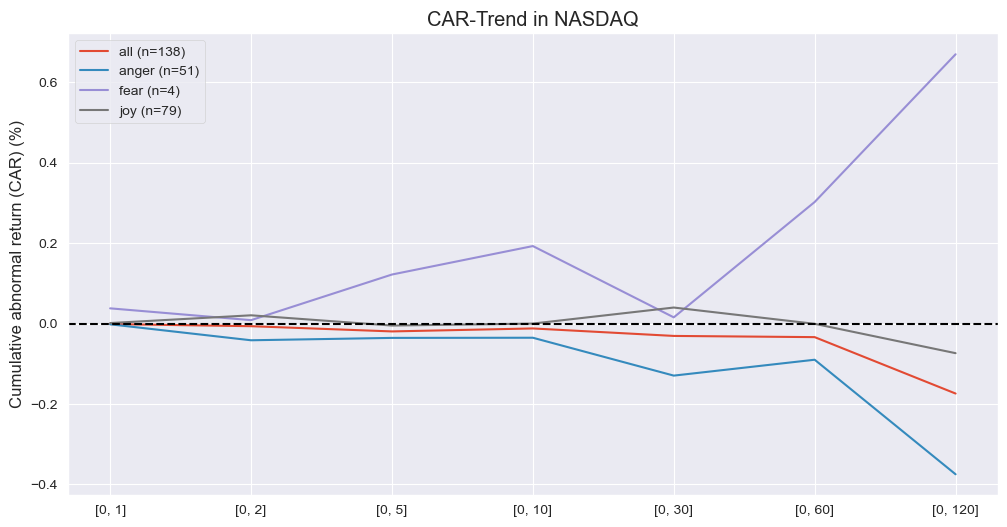

In [24]:
#### 1. Summary of significant effects (NASDAQ) ###
significant_results = df_nasdaq_car_results[
    (df_nasdaq_car_results['t_stat'].str.contains(r'\*\*', na=False)) |
    (df_nasdaq_car_results['t_stat'].str.contains(r'\*', na=False))
]

# 2. Visualisierung der CAR-Entwicklung
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for emotion in ['all', 'anger', 'fear', 'joy']:
    subset = df_nasdaq_car_results[df_nasdaq_car_results['emotion'] == emotion]
    plt.plot(subset['window'], subset['mean_car'].str.replace(' %','').astype(float),
             label=f"{emotion} (n={subset['n_events'].iloc[0]})")

plt.axhline(0, color='black', linestyle='--')
plt.title("CAR-Trend in NASDAQ")
plt.ylabel("Cumulative abnormal return (CAR) (%)")
plt.legend()
plt.show()

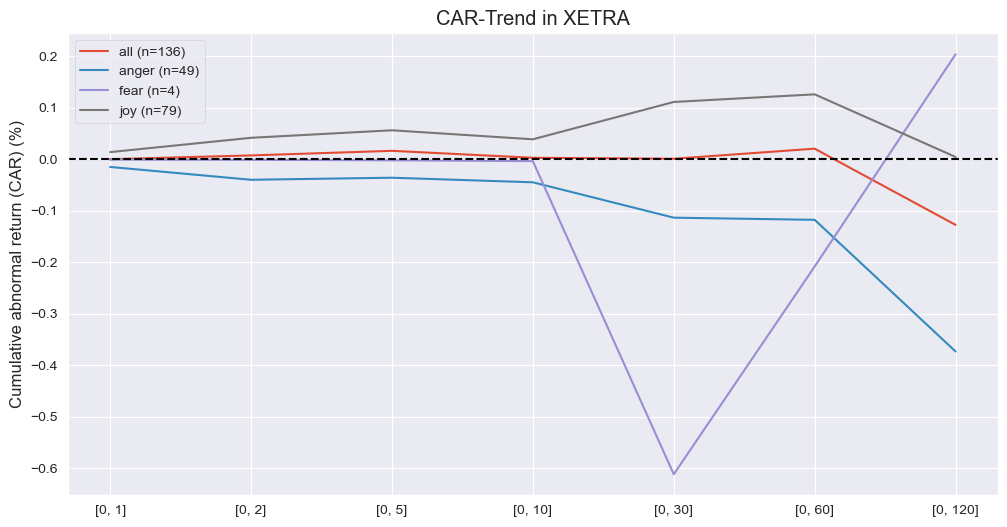

In [25]:
#### 2. Summary of significant effects (XETRA) ###
significant_results = df_xetra_car_results[
    (df_xetra_car_results['t_stat'].str.contains(r'\*\*', na=False)) |
    (df_xetra_car_results['t_stat'].str.contains(r'\*', na=False))
]

# 2. Visualisierung der CAR-Entwicklung
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for emotion in ['all', 'anger', 'fear', 'joy']:
    subset = df_xetra_car_results[df_xetra_car_results['emotion'] == emotion]
    plt.plot(subset['window'], subset['mean_car'].str.replace(' %','').astype(float),
             label=f"{emotion} (n={subset['n_events'].iloc[0]})")

plt.axhline(0, color='black', linestyle='--')
plt.title("CAR-Trend in XETRA")
plt.ylabel("Cumulative abnormal return (CAR) (%)")
plt.legend()
plt.show()

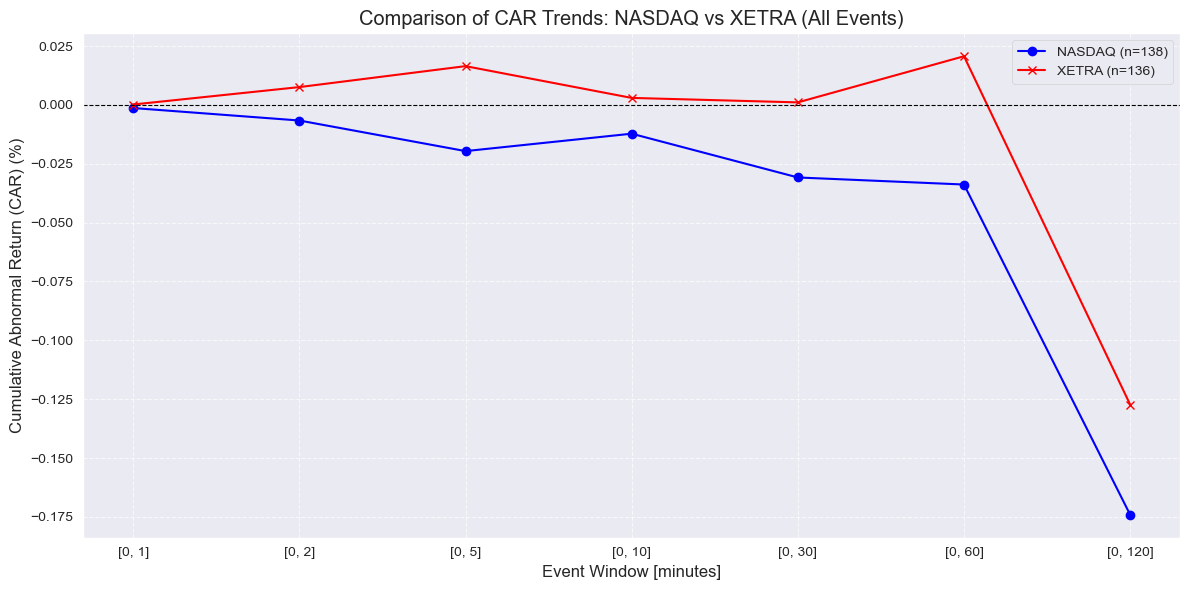

In [26]:
### Compare both ALL Graphs in one Chart ###

# Daten vorbereiten
nasdaq_all = df_nasdaq_car_results[df_nasdaq_car_results['emotion'] == 'all']
xetra_all = df_xetra_car_results[df_xetra_car_results['emotion'] == 'all']

# Plot erstellen
plt.figure(figsize=(12, 6))

# NASDAQ Linie
plt.plot(nasdaq_all['window'],
         nasdaq_all['mean_car'].str.replace(' %','').astype(float),
         label='NASDAQ (n={})'.format(nasdaq_all['n_events'].iloc[0]),
         color='blue',
         marker='o')

# XETRA Linie
plt.plot(xetra_all['window'],
         xetra_all['mean_car'].str.replace(' %','').astype(float),
         label='XETRA (n={})'.format(xetra_all['n_events'].iloc[0]),
         color='red',
         marker='x')

# Plot-Elemente
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Comparison of CAR Trends: NASDAQ vs XETRA (All Events)')
plt.xlabel('Event Window [minutes]')
plt.ylabel('Cumulative Abnormal Return (CAR) (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

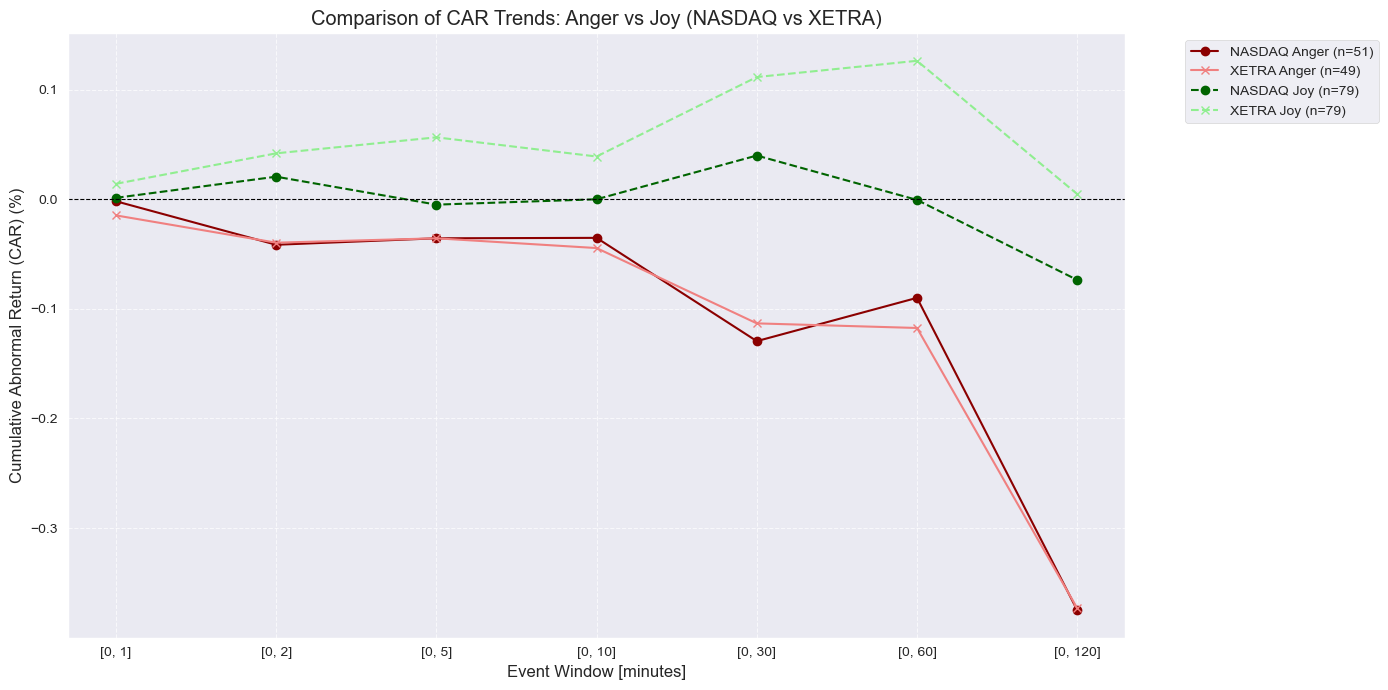

In [27]:
### Compare Emotions across stock exchanges in one graph ###
# Daten vorbereiten
nasdaq_anger = df_nasdaq_car_results[df_nasdaq_car_results['emotion'] == 'anger']
xetra_anger = df_xetra_car_results[df_xetra_car_results['emotion'] == 'anger']
nasdaq_joy = df_nasdaq_car_results[df_nasdaq_car_results['emotion'] == 'joy']
xetra_joy = df_xetra_car_results[df_xetra_car_results['emotion'] == 'joy']

# Plot erstellen
plt.figure(figsize=(14, 7))

# NASDAQ Anger
plt.plot(nasdaq_anger['window'],
         nasdaq_anger['mean_car'].str.replace(' %','').astype(float),
         label='NASDAQ Anger (n={})'.format(nasdaq_anger['n_events'].iloc[0]),
         color='darkred',
         linestyle='-',
         marker='o')

# XETRA Anger
plt.plot(xetra_anger['window'],
         xetra_anger['mean_car'].str.replace(' %','').astype(float),
         label='XETRA Anger (n={})'.format(xetra_anger['n_events'].iloc[0]),
         color='lightcoral',
         linestyle='-',
         marker='x')

# NASDAQ Joy
plt.plot(nasdaq_joy['window'],
         nasdaq_joy['mean_car'].str.replace(' %','').astype(float),
         label='NASDAQ Joy (n={})'.format(nasdaq_joy['n_events'].iloc[0]),
         color='darkgreen',
         linestyle='--',
         marker='o')

# XETRA Joy
plt.plot(xetra_joy['window'],
         xetra_joy['mean_car'].str.replace(' %','').astype(float),
         label='XETRA Joy (n={})'.format(xetra_joy['n_events'].iloc[0]),
         color='lightgreen',
         linestyle='--',
         marker='x')

# Plot-Elemente
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Comparison of CAR Trends: Anger vs Joy (NASDAQ vs XETRA)')
plt.xlabel('Event Window [minutes]')
plt.ylabel('Cumulative Abnormal Return (CAR) (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()